# Preliminary Analysis of CoronaVirus Time Series Data
In this notebook we will conduct some preliminary analysis and forecasting on the Coronavirus time seires data. For this analysis we will look at 

**Warning this is a basic analysis/machine learning model. The goal of this notebook is to gage the utility of data augmentation/transfer learning for virus forecasting. NOT provide actionable insights. It would additional rounds of training/validation + verification by epidemiologists and public health experts before I would be confident relying on using it for any actionable insights**

In [1]:
#!git clone https://github.com/CoronaWhy/task-geo.git
#!os.chdir('task-geo')
import pandas as pd
!wget -O coronavirus_timeseries.csv https://coronadatascraper.com/timeseries.csv
!pip install wandb
!wandb login
import wandb
from tensorflow import keras
from wandb.keras import WandbCallback 

--2020-04-27 23:10:50--  https://coronadatascraper.com/timeseries.csv
Resolving coronadatascraper.com (coronadatascraper.com)... 185.199.108.153, 185.199.111.153, 185.199.110.153
Connecting to coronadatascraper.com (coronadatascraper.com)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35511358 (34M) [text/csv]
Saving to: ‘coronavirus_timeseries.csv’

coronavirus_timeser 100%[===================>]  33.87M  72.5MB/s    in 0.5s    

2020-04-27 23:10:51 (72.5 MB/s) - ‘coronavirus_timeseries.csv’ saved [35511358/35511358]

     |████████████████████████████████| 1.4MB 4.9MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 102kB 9.5MB/s 
     |████████████████████████████████| 460kB 24.4MB/s 
     |████████████████████████████████| 112kB 36.9MB/s 
     |████████████████████████████████| 71kB 10.8MB/s 
     |████████████████████████████████| 71kB 10.4MB/s 
  Created wheel for watchdog: filename=watchd

In [2]:
df = pd.read_csv("coronavirus_timeseries.csv")
df['month'] = pd.to_datetime(df['date']).map(lambda x: x.month)
df['weekday'] = pd.to_datetime(df['date']).map(lambda x: x.weekday())

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [23]:
unqiue_counties = df['county'].unique()
print(len(unqiue_counties))

2015


## Forecasting in Antwerp

In [3]:
antwerp_df = df[df['county']=='Antwerp'].fillna(0)
antwerp_relevant = antwerp_df[['cases', 'deaths', 'recovered', 'population', 'lat', 'long']].values
antwerp_df['new_cases'] = antwerp_df.cases.diff()
#antwerp_df.tail()
print(len(antwerp_df))

96


## Data Augmentation
We will now explore using the tsaug library for forecasting.

In [0]:
!pip install tsaug

In [0]:
from tsaug.visualization import plot 
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
my_augmenter = (TimeWarp() * 5, # random time warping 5 times in parallel 
                Crop(size=300),  # random crop subsequences with length 300
                Quantize(n_levels=[10, 20, 30]),  # random quantize to 10-, 20-, or 30- level sets
                Drift(max_drift=(0.1, 0.5)),   # with 80% probability, random drift the signal up to 10% - 50%
                Reverse()) #0.5  # with 50% probability, reverse the sequence)

In [0]:
#X_aug = my_augmenter[0].augment(antwerp_relevant)
print(antwerp_relevant.shape)
X_aug = TimeWarp(antwerp[:70])

## Models and Forecasting
We will now define some simple models in Keras for forecasting.

In [0]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import RobustScaler
scaler_dict = {}
config_default = {"epochs":30, "validation_split":0.1, 
          "loss":"mean_squared_error", "optimizer":'adam', 
          "geo_segment":"antwerp", "seq_len":7, "train_steps":70, 
          "test_steps":27, "scaler":"RobustScaler", "new_cases":True, 
          "beta":0.899, "additional_features":["weekday","month"]}
r = RobustScaler()
x_train_full = antwerp_df[['deaths', 'new_cases']][1:config_default["train_steps"]]
x_train_full = pd.DataFrame(r.fit_transform(x_train_full))
y_train_full = x_train_full
r_test = RobustScaler()
test_orig = antwerp_df[['deaths', 'new_cases']][70:]
test = pd.DataFrame(r_test.fit_transform(test_orig))

In [0]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)



In [6]:
sweep_config = {
  "name": "Default sweep",
  "method": "grid",
  "parameters": {
        "batch_size": {
            "values": [2, 3, 4, 5]
        },
        "learn":{
            "values":[0.001, 0.0015, 0.002, 0.003, 0.004, 0.01]
        },
        "seq_len":{
            "values":[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
        }
    }
}
sweep_id = wandb.sweep(sweep_config, project="covid-forecast")

Create sweep with ID: 9utnx2a4
Sweep URL: https://app.wandb.ai/igodfried/covid-forecast/sweeps/9utnx2a4


In [0]:
import matplotlib.pyplot as plt
def train():
  run = wandb.init(project="covid-forecast", config=config_default, magic=True)
  config = wandb.config
  X_train, Y_train = create_dataset(x_train_full, y_train_full, config["seq_len"])
  X_test, y_test = create_dataset(test, test, config["seq_len"])
  opt = keras.optimizers.Adam(learning_rate=config["learn"], beta_1=config["beta"], beta_2=0.999, amsgrad=False)
  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128,
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  ) 
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=2))
  model.compile(loss=config["loss"], optimizer=opt)

  history = model.fit(
      X_train, Y_train,
      epochs=config["epochs"],
      batch_size=config["batch_size"],
      validation_split=config["validation_split"],
      callbacks=[WandbCallback()],
      shuffle=False
  )
  evaluate_single(model, X_test, y_test, r)
  evaluate_plot_multi(model, test, config, X_test, r_test)
  return model

def evaluate_single(model, x_test, y_test, scaler):
  y_preds = model.predict(x_test)
  y_preds = scaler.inverse_transform(y_preds)
  y_test = scaler.inverse_transform(y_test)
  complete_mse = tf.keras.losses.MSE( y_preds[:, 1], y_test[:, 1])
  wandb.run.summary["test_mse"] = complete_mse
  return complete_mse

def evaluate_plot_multi(model, test_df, config, x_test, scaler, predictor="new_cases"):
  arr = predict_multi(model, len(test)-config["seq_len"], x_test[0, :, :], config)
  test_orig['predicted_cases'] = 0
  test_orig['predicted_cases'][config["seq_len"]:] = scaler.inverse_transform(arr.squeeze(0))[:, 1]
  plt.plot(test_orig['predicted_cases'], label='predicted_cases')
  plt.plot(test_orig[predictor], label='actual_cases')
  plt.legend();
  wandb.log({"test":plt})
  large_mse = tf.keras.losses.MSE(
    scaler.inverse_transform(arr.squeeze(0))[:, 1], test_orig[predictor][config["seq_len"]:].values
  )
  wandb.run.summary["test_mse_full"] =  large_mse
  return large_mse

def predict_multi(model, time_steps, start_rows, config):
  start_rows=np.expand_dims(start_rows, axis=0)
  for i in range(0, time_steps):
    out = model.predict(start_rows[:, i:, :])
    out = out[np.newaxis, ...]
    start_rows = np.concatenate((start_rows, out), axis=1)
  return start_rows[:, config["seq_len"]:, :]


In [0]:
wandb.agent(sweep_id, function=train)

wandb: Agent Starting Run: yreg3cd9 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 1
wandb: Agent Started Run: yreg3cd9


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 27ms/step - loss: 1.0074 - val_loss: 13.6573
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 0.8409 - val_loss: 11.1218
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.7034 - val_loss: 9.0567
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 0.5928 - val_loss: 7.1811
Epoch 5/30
31/31 [==============================] - 0s 8ms/step - loss: 0.4882 - val_loss: 5.5326
Epoch 6/30
31/3

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yreg3cd9 

wandb: Agent Starting Run: g7mymzik with config:
	batch_size: 2
	learn: 0.001
	seq_len: 2
wandb: Agent Started Run: g7mymzik


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 27ms/step - loss: 0.7669 - val_loss: 11.8339
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5027 - val_loss: 6.3182
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3294 - val_loss: 2.9897
Epoch 4/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2601 - val_loss: 1.7165
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2048 - val_loss: 1.8247
Epoch 6/30
30/30

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: g7mymzik 

wandb: Agent Starting Run: dztb9eoo with config:
	batch_size: 2
	learn: 0.001
	seq_len: 3
wandb: Agent Started Run: dztb9eoo


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.8119 - val_loss: 7.9036
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3753 - val_loss: 1.9536
Epoch 3/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2202 - val_loss: 1.8466
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.1967 - val_loss: 2.5495
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.1954 - val_loss: 2.9851
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dztb9eoo 

wandb: Agent Starting Run: wqikwzoe with config:
	batch_size: 2
	learn: 0.001
	seq_len: 4
wandb: Agent Started Run: wqikwzoe


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 28ms/step - loss: 0.6046 - val_loss: 6.8300
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2298 - val_loss: 1.3153
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1853 - val_loss: 2.1319
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1623 - val_loss: 1.9232
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1731 - val_loss: 2.5784
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wqikwzoe 

wandb: Agent Starting Run: m37ajp68 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 5
wandb: Agent Started Run: m37ajp68


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 28ms/step - loss: 0.8423 - val_loss: 6.6329
Epoch 2/30
29/29 [==============================] - 0s 8ms/step - loss: 0.1988 - val_loss: 1.3146
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2044 - val_loss: 2.9451
Epoch 4/30
29/29 [==============================] - 0s 8ms/step - loss: 0.2343 - val_loss: 2.0969
Epoch 5/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2250 - val_loss: 3.4723
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: m37ajp68 

wandb: Agent Starting Run: oz5egf06 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 6
wandb: Agent Started Run: oz5egf06


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 29ms/step - loss: 0.4251 - val_loss: 3.0005
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.1995 - val_loss: 1.8155
Epoch 3/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1781 - val_loss: 2.0779
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1913 - val_loss: 2.9390
Epoch 5/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1947 - val_loss: 2.8273
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: oz5egf06 

wandb: Agent Starting Run: x1nsnv5r with config:
	batch_size: 2
	learn: 0.001
	seq_len: 7
wandb: Agent Started Run: x1nsnv5r


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.5343 - val_loss: 2.4558
Epoch 2/30
28/28 [==============================] - 0s 8ms/step - loss: 0.2216 - val_loss: 2.1530
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.1890 - val_loss: 2.1998
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.2739 - val_loss: 2.8930
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.5358 - val_loss: 2.8605
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: x1nsnv5r 

wandb: Agent Starting Run: yg0ugbyk with config:
	batch_size: 2
	learn: 0.001
	seq_len: 8
wandb: Agent Started Run: yg0ugbyk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.3658 - val_loss: 1.9926
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2265 - val_loss: 2.0345
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2060 - val_loss: 1.5249
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2138 - val_loss: 2.7311
Epoch 5/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2640 - val_loss: 1.6358
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: yg0ugbyk 



wandb: Network error resolved after 0:00:13.749666, resuming normal operation.


wandb: Agent Starting Run: 6amngam7 with config:
	batch_size: 2
	learn: 0.001
	seq_len: 10
wandb: Agent Started Run: 6amngam7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 31ms/step - loss: 0.6110 - val_loss: 1.9992
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.3617 - val_loss: 2.0712
Epoch 3/30
27/27 [==============================] - 0s 8ms/step - loss: 0.3790 - val_loss: 1.9963
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 0.4744 - val_loss: 2.7024
Epoch 5/30
27/27 [==============================] - 0s 8ms/step - loss: 0.7650 - val_loss: 3.5749
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6amngam7 

wandb: Agent Starting Run: onm2ntot with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 1
wandb: Agent Started Run: onm2ntot


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 27ms/step - loss: 0.9597 - val_loss: 12.5820
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 0.6891 - val_loss: 8.7316
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.5054 - val_loss: 5.8744
Epoch 4/30
31/31 [==============================] - 0s 9ms/step - loss: 0.3875 - val_loss: 3.8045
Epoch 5/30
31/31 [==============================] - 0s 7ms/step - loss: 0.3036 - val_loss: 2.5400
Epoch 6/30
31/31

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: onm2ntot 

wandb: Agent Starting Run: 6w598ykn with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 2
wandb: Agent Started Run: 6w598ykn


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 27ms/step - loss: 0.6647 - val_loss: 8.8291
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3185 - val_loss: 2.8695
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2323 - val_loss: 1.7688
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2003 - val_loss: 2.4312
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.1974 - val_loss: 2.6179
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 6w598ykn 

wandb: Agent Starting Run: douljuon with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 3
wandb: Agent Started Run: douljuon


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.5932 - val_loss: 4.1357
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2151 - val_loss: 1.7189
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.1900 - val_loss: 2.8149
Epoch 4/30
30/30 [==============================] - 0s 9ms/step - loss: 0.1735 - val_loss: 2.7612
Epoch 5/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2166 - val_loss: 2.8903
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: douljuon 

wandb: Agent Starting Run: z28zgjab with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 4
wandb: Agent Started Run: z28zgjab


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 29ms/step - loss: 0.4249 - val_loss: 3.1415
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2500 - val_loss: 1.7846
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.1984 - val_loss: 1.7038
Epoch 4/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2410 - val_loss: 2.7263
Epoch 5/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2877 - val_loss: 2.5582
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: z28zgjab 

wandb: Agent Starting Run: 1tdp3jwq with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 5
wandb: Agent Started Run: 1tdp3jwq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 29ms/step - loss: 0.3823 - val_loss: 1.3564
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.3157 - val_loss: 3.3603
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.4956 - val_loss: 1.6535
Epoch 4/30
29/29 [==============================] - 0s 8ms/step - loss: 0.2662 - val_loss: 2.6373
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.4373 - val_loss: 2.8058
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 1tdp3jwq 

wandb: Agent Starting Run: mzuxkhb4 with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 6
wandb: Agent Started Run: mzuxkhb4


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 29ms/step - loss: 0.2384 - val_loss: 1.3094
Epoch 2/30
28/28 [==============================] - 0s 6ms/step - loss: 0.3074 - val_loss: 2.1782
Epoch 3/30
28/28 [==============================] - 0s 6ms/step - loss: 0.3679 - val_loss: 1.7024
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1937 - val_loss: 2.5824
Epoch 5/30
28/28 [==============================] - 0s 6ms/step - loss: 0.2065 - val_loss: 2.1955
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mzuxkhb4 

wandb: Agent Starting Run: 5kdw9o6z with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 7
wandb: Agent Started Run: 5kdw9o6z


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.2190 - val_loss: 1.8014
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4702 - val_loss: 2.1976
Epoch 3/30
28/28 [==============================] - 0s 8ms/step - loss: 0.6463 - val_loss: 1.7904
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.1966 - val_loss: 2.0715
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.3394 - val_loss: 1.3179
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 5kdw9o6z 

wandb: Agent Starting Run: i2kwvefh with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 8
wandb: Agent Started Run: i2kwvefh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.2703 - val_loss: 1.2707
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2942 - val_loss: 1.7703
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.3387 - val_loss: 1.6072
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: 0.3019 - val_loss: 2.0292
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4522 - val_loss: 2.8060
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: i2kwvefh 

wandb: Agent Starting Run: ue4051aa with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 9
wandb: Agent Started Run: ue4051aa


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.1937 - val_loss: 2.1321
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4413 - val_loss: 2.0731
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.3401 - val_loss: 2.6353
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 0.7132 - val_loss: 1.9032
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 1.0091 - val_loss: 8.6561
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: ue4051aa 

wandb: Agent Starting Run: 37ylrcdj with config:
	batch_size: 2
	learn: 0.0015
	seq_len: 10
wandb: Agent Started Run: 37ylrcdj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 31ms/step - loss: 0.2018 - val_loss: 1.9202
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4029 - val_loss: 3.1868
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2581 - val_loss: 4.0508
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4130 - val_loss: 2.3896
Epoch 5/30
27/27 [==============================] - 0s 8ms/step - loss: 0.4797 - val_loss: 2.4263
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 37ylrcdj 

wandb: Agent Starting Run: joqaki9j with config:
	batch_size: 2
	learn: 0.002
	seq_len: 1
wandb: Agent Started Run: joqaki9j


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 27ms/step - loss: 0.8588 - val_loss: 10.8526
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 0.5243 - val_loss: 6.3779
Epoch 3/30
31/31 [==============================] - 0s 8ms/step - loss: 0.3868 - val_loss: 3.4589
Epoch 4/30
31/31 [==============================] - 0s 9ms/step - loss: 0.2703 - val_loss: 2.0505
Epoch 5/30
31/31 [==============================] - 0s 7ms/step - loss: 0.2348 - val_loss: 1.7625
Epoch 6/30
31/31

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: joqaki9j 

wandb: Agent Starting Run: 138rgqan with config:
	batch_size: 2
	learn: 0.002
	seq_len: 2
wandb: Agent Started Run: 138rgqan


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.5169 - val_loss: 5.5046
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2513 - val_loss: 1.6529
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2058 - val_loss: 2.7010
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.1846 - val_loss: 2.9480
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2085 - val_loss: 2.9190
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 138rgqan 

wandb: Agent Starting Run: mll6a5sx with config:
	batch_size: 2
	learn: 0.002
	seq_len: 3
wandb: Agent Started Run: mll6a5sx


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.3705 - val_loss: 1.4928
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3125 - val_loss: 3.2522
Epoch 3/30
30/30 [==============================] - 0s 8ms/step - loss: 0.4017 - val_loss: 1.4539
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2903 - val_loss: 3.4214
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.3843 - val_loss: 1.9327
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: mll6a5sx 

wandb: Agent Starting Run: sy3ms8qh with config:
	batch_size: 2
	learn: 0.002
	seq_len: 4
wandb: Agent Started Run: sy3ms8qh


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 28ms/step - loss: 0.2384 - val_loss: 1.2690
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2882 - val_loss: 2.9658
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2827 - val_loss: 1.7003
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2723 - val_loss: 2.8789
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.3306 - val_loss: 3.4974
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sy3ms8qh 

wandb: Agent Starting Run: 0aeuuznq with config:
	batch_size: 2
	learn: 0.002
	seq_len: 5
wandb: Agent Started Run: 0aeuuznq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 29ms/step - loss: 0.2084 - val_loss: 2.1301
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.5557 - val_loss: 2.3867
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.8111 - val_loss: 4.1004
Epoch 4/30
29/29 [==============================] - 0s 9ms/step - loss: 0.1673 - val_loss: 1.6526
Epoch 5/30
29/29 [==============================] - 0s 8ms/step - loss: 0.2039 - val_loss: 2.4477
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0aeuuznq 

wandb: Agent Starting Run: 0ih6dugy with config:
	batch_size: 2
	learn: 0.002
	seq_len: 6
wandb: Agent Started Run: 0ih6dugy


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 31ms/step - loss: 0.1909 - val_loss: 1.2710
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.2298 - val_loss: 1.9388
Epoch 3/30
28/28 [==============================] - 0s 6ms/step - loss: 0.2125 - val_loss: 2.3053
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 0.2599 - val_loss: 3.0159
Epoch 5/30
28/28 [==============================] - 0s 7ms/step - loss: 0.2229 - val_loss: 3.0273
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 0ih6dugy 

wandb: Agent Starting Run: xy5ysiyu with config:
	batch_size: 2
	learn: 0.002
	seq_len: 7
wandb: Agent Started Run: xy5ysiyu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.1872 - val_loss: 1.7636
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4938 - val_loss: 1.9738
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.2506 - val_loss: 2.3927
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.6070 - val_loss: 1.8276
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.9847 - val_loss: 7.4220
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xy5ysiyu 

wandb: Agent Starting Run: wf7hm5mq with config:
	batch_size: 2
	learn: 0.002
	seq_len: 8
wandb: Agent Started Run: wf7hm5mq


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.2422 - val_loss: 1.1664
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2302 - val_loss: 1.7053
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2013 - val_loss: 1.8300
Epoch 4/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2569 - val_loss: 2.4762
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 0.3209 - val_loss: 2.2196
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wf7hm5mq 

wandb: Agent Starting Run: xjar34j5 with config:
	batch_size: 2
	learn: 0.002
	seq_len: 9
wandb: Agent Started Run: xjar34j5


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.1681 - val_loss: 1.7353
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.3899 - val_loss: 2.0173
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2539 - val_loss: 2.0870
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 0.4121 - val_loss: 1.5770
Epoch 5/30
27/27 [==============================] - 0s 6ms/step - loss: 0.3875 - val_loss: 1.8690
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: xjar34j5 

wandb: Agent Starting Run: 8sloa8fu with config:
	batch_size: 2
	learn: 0.002
	seq_len: 10
wandb: Agent Started Run: 8sloa8fu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 31ms/step - loss: 0.2470 - val_loss: 1.4504
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4582 - val_loss: 2.8695
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4030 - val_loss: 1.8759
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 0.6314 - val_loss: 1.7751
Epoch 5/30
27/27 [==============================] - 0s 8ms/step - loss: 0.3926 - val_loss: 1.9125
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 8sloa8fu 

wandb: Agent Starting Run: pe4yoaa2 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 1
wandb: Agent Started Run: pe4yoaa2


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

31/31 [==============================] - 1s 27ms/step - loss: 0.6761 - val_loss: 7.8590
Epoch 2/30
31/31 [==============================] - 0s 7ms/step - loss: 0.3532 - val_loss: 2.9136
Epoch 3/30
31/31 [==============================] - 0s 7ms/step - loss: 0.2421 - val_loss: 1.7461
Epoch 4/30
31/31 [==============================] - 0s 7ms/step - loss: 0.2270 - val_loss: 1.8894
Epoch 5/30
31/31 [==============================] - 0s 6ms/step - loss: 0.2452 - val_loss: 2.0292
Epoch 6/30
31/31 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: pe4yoaa2 

wandb: Agent Starting Run: dh9ibkv3 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 2
wandb: Agent Started Run: dh9ibkv3


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 29ms/step - loss: 0.3686 - val_loss: 2.7090
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2521 - val_loss: 2.6561
Epoch 3/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2071 - val_loss: 2.1877
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.1896 - val_loss: 1.9292
Epoch 5/30
30/30 [==============================] - 0s 8ms/step - loss: 0.2207 - val_loss: 2.6117
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: dh9ibkv3 



wandb: Network error resolved after 0:00:16.160168, resuming normal operation.


wandb: Agent Starting Run: eqohgdcr with config:
	batch_size: 2
	learn: 0.003
	seq_len: 4
wandb: Agent Started Run: eqohgdcr


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 28ms/step - loss: 0.1810 - val_loss: 1.3390
Epoch 2/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2825 - val_loss: 2.0108
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1919 - val_loss: 1.9420
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1928 - val_loss: 2.4279
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.2832 - val_loss: 2.5347
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: eqohgdcr 

wandb: Agent Starting Run: rlby3u4w with config:
	batch_size: 2
	learn: 0.003
	seq_len: 5
wandb: Agent Started Run: rlby3u4w


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 30ms/step - loss: 0.2108 - val_loss: 1.5399
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.4875 - val_loss: 2.1061
Epoch 3/30
29/29 [==============================] - 0s 7ms/step - loss: 0.2116 - val_loss: 2.7603
Epoch 4/30
29/29 [==============================] - 0s 9ms/step - loss: 0.2338 - val_loss: 3.2407
Epoch 5/30
29/29 [==============================] - 0s 7ms/step - loss: 0.5303 - val_loss: 2.8805
Epoch 6/30
29/29 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: rlby3u4w 

wandb: Agent Starting Run: wo29qb9q with config:
	batch_size: 2
	learn: 0.003
	seq_len: 6
wandb: Agent Started Run: wo29qb9q


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 29ms/step - loss: 0.2262 - val_loss: 1.7294
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.3120 - val_loss: 1.4399
Epoch 3/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1865 - val_loss: 1.5515
Epoch 4/30
28/28 [==============================] - 0s 6ms/step - loss: 0.1865 - val_loss: 1.7769
Epoch 5/30
28/28 [==============================] - 0s 6ms/step - loss: 0.2221 - val_loss: 2.0451
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wo29qb9q 

wandb: Agent Starting Run: wqo4udpk with config:
	batch_size: 2
	learn: 0.003
	seq_len: 7
wandb: Agent Started Run: wqo4udpk


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

28/28 [==============================] - 1s 30ms/step - loss: 0.2113 - val_loss: 1.2090
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4540 - val_loss: 2.5426
Epoch 3/30
28/28 [==============================] - 0s 7ms/step - loss: 0.4526 - val_loss: 1.3873
Epoch 4/30
28/28 [==============================] - 0s 8ms/step - loss: 0.6755 - val_loss: 2.3378
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.2941 - val_loss: 1.3291
Epoch 6/30
28/28 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: wqo4udpk 

wandb: Agent Starting Run: sx7q38e7 with config:
	batch_size: 2
	learn: 0.003
	seq_len: 8
wandb: Agent Started Run: sx7q38e7


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 30ms/step - loss: 0.2472 - val_loss: 1.2863
Epoch 2/30
27/27 [==============================] - 0s 8ms/step - loss: 0.3866 - val_loss: 2.0604
Epoch 3/30
27/27 [==============================] - 0s 6ms/step - loss: 0.5549 - val_loss: 1.4766
Epoch 4/30
27/27 [==============================] - 0s 7ms/step - loss: 0.7668 - val_loss: 7.4296
Epoch 5/30
27/27 [==============================] - 0s 8ms/step - loss: 0.2468 - val_loss: 1.1504
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sx7q38e7 

wandb: Agent Starting Run: 9xjtt72f with config:
	batch_size: 2
	learn: 0.003
	seq_len: 9
wandb: Agent Started Run: 9xjtt72f


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 31ms/step - loss: 0.2802 - val_loss: 1.4501
Epoch 2/30
27/27 [==============================] - 0s 6ms/step - loss: 0.2016 - val_loss: 6.4499
Epoch 3/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2429 - val_loss: 1.2284
Epoch 4/30
27/27 [==============================] - 0s 6ms/step - loss: 0.5828 - val_loss: 2.6303
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2664 - val_loss: 1.9957
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: 9xjtt72f 

wandb: Agent Starting Run: lzv1g2xu with config:
	batch_size: 2
	learn: 0.003
	seq_len: 10
wandb: Agent Started Run: lzv1g2xu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

27/27 [==============================] - 1s 31ms/step - loss: 0.3961 - val_loss: 1.5448
Epoch 2/30
27/27 [==============================] - 0s 7ms/step - loss: 0.4896 - val_loss: 5.4202
Epoch 3/30
27/27 [==============================] - 0s 8ms/step - loss: 0.7021 - val_loss: 2.9584
Epoch 4/30
27/27 [==============================] - 0s 8ms/step - loss: 0.2120 - val_loss: 2.9373
Epoch 5/30
27/27 [==============================] - 0s 7ms/step - loss: 0.2114 - val_loss: 2.8213
Epoch 6/30
27/27 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: lzv1g2xu 



wandb: Network error resolved after 0:00:12.626176, resuming normal operation.


wandb: Agent Starting Run: f7kpfj8k with config:
	batch_size: 2
	learn: 0.004
	seq_len: 2
wandb: Agent Started Run: f7kpfj8k


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.2788 - val_loss: 1.7188
Epoch 2/30
30/30 [==============================] - 0s 6ms/step - loss: 0.3052 - val_loss: 3.2003
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2536 - val_loss: 1.6374
Epoch 4/30
30/30 [==============================] - 0s 6ms/step - loss: 0.2336 - val_loss: 2.5935
Epoch 5/30
30/30 [==============================] - 0s 7ms/step - loss: 0.2687 - val_loss: 1.6093
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: f7kpfj8k 

wandb: Agent Starting Run: sotggoyu with config:
	batch_size: 2
	learn: 0.004
	seq_len: 3
wandb: Agent Started Run: sotggoyu


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

30/30 [==============================] - 1s 28ms/step - loss: 0.2051 - val_loss: 2.3640
Epoch 2/30
30/30 [==============================] - 0s 7ms/step - loss: 0.5277 - val_loss: 1.7383
Epoch 3/30
30/30 [==============================] - 0s 7ms/step - loss: 0.4646 - val_loss: 1.6305
Epoch 4/30
30/30 [==============================] - 0s 8ms/step - loss: 0.4650 - val_loss: 2.3359
Epoch 5/30
30/30 [==============================] - 0s 6ms/step - loss: 0.8228 - val_loss: 5.8774
Epoch 6/30
30/30 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:410: UserWarning:

Bummer! Plotly can currently only draw Line2D objects from matplotlib that are in 'data' coordinates!

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



wandb: Agent Finished Run: sotggoyu 

wandb: Agent Starting Run: valad6xj with config:
	batch_size: 2
	learn: 0.004
	seq_len: 4
wandb: Agent Started Run: valad6xj


Epoch 1/30

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

29/29 [==============================] - 1s 28ms/step - loss: 0.2464 - val_loss: 1.9846
Epoch 2/30
29/29 [==============================] - 0s 7ms/step - loss: 0.3375 - val_loss: 1.3275
Epoch 3/30
29/29 [==============================] - 0s 6ms/step - loss: 0.1986 - val_loss: 1.3872
Epoch 4/30
29/29 [==============================] - 0s 6ms/step - loss: 0.3660 - val_loss: 1.9561
Epoch 5/30
29/29 [==============================] - 0s 6ms/step - loss: 0.3432 - val_loss: 2.8187
Epoch 6/30
29/29 

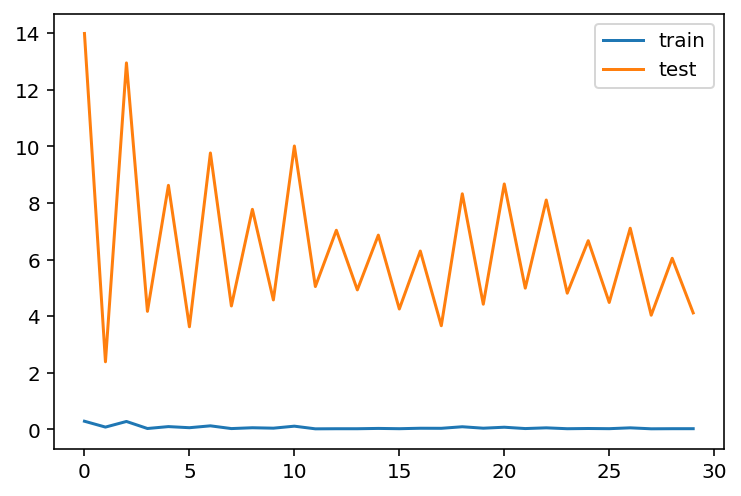

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

### Examining Results
We will now predict both one step ahead and 20 steps ahead.

In [0]:
res = model.predict(X_test)
res = r_test.inverse_transform(res)
res

array([[-2.1279370e-02,  2.0092883e+03],
       [-1.8879963e-02,  2.2472920e+03],
       [-1.6375745e-02,  2.5275439e+03],
       [-1.3892809e-02,  2.8506108e+03],
       [-1.1596879e-02,  3.1829221e+03],
       [-9.0861954e-03,  3.5029392e+03],
       [-6.4477865e-03,  3.7825161e+03],
       [-3.6051013e-03,  4.0421055e+03],
       [-1.2287628e-03,  4.2927124e+03],
       [ 3.3153594e-04,  4.5448154e+03],
       [ 1.1798348e-03,  4.7915127e+03],
       [ 2.0689592e-03,  5.0360225e+03],
       [ 3.3188127e-03,  5.2662153e+03],
       [ 5.0343592e-03,  5.5053794e+03],
       [ 6.5031778e-03,  5.7533242e+03],
       [ 7.2021466e-03,  5.9751943e+03],
       [ 7.6369299e-03,  6.1531494e+03]], dtype=float32)

In [0]:
y_true = r_test.inverse_transform(y_test)
y_true

array([[   0., 3521.],
       [   0., 3822.],
       [   0., 4086.],
       [   0., 4179.],
       [   0., 4265.],
       [   0., 4330.],
       [   0., 4470.],
       [   0., 4645.],
       [   0., 4855.],
       [   0., 4965.],
       [   0., 5028.],
       [   0., 5079.],
       [   0., 5241.],
       [   0., 5415.],
       [   0., 5449.],
       [   0., 5449.],
       [   0., 5449.]])

### PyTorch models
Use flow-forecast library


In [0]:
from google.colab import auth
from datetime import datetime
auth.authenticate_user()
!gcloud source repos clone github_aistream-peelout_flow-forecast --project=gmap-997

In [0]:
import os
os.chdir('/content/github_aistream-peelout_flow-forecast')
!git checkout -t origin/branch_fixes
!python setup.py develop
!pip install -r requirements.txt
!mkdir data